<a href="https://colab.research.google.com/github/orgoca/W207FinalProject/blob/main/project2EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2 Baseline
Quora Project



# Load Data and Import Libraries

First, we load all data and necessary libraries. We split the `train` data into `miniTrain` and `miniTest` dataframes.



In [2]:
#Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, plot_confusion_matrix
from sklearn_pandas import DataFrameMapper
import csv
import random

In [12]:
columns = [
    "id",
    "label",
    "alpha",
    "text"
]

miniTrain = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/train.tsv', names=columns, sep="\t")

miniTest = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/test.tsv', names=columns, sep="\t")

miniDev = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/dev.tsv', names=columns, sep="\t")

In [5]:
miniTrain

,id,label,alpha,text
0,0,0,a,What is the most effective classroom managemen...
1,1,0,a,Can I study abroad after 10th class from Bangl...
2,2,0,a,How can I make friends as a college junior?
3,3,0,a,How do I download free APK Minecraft: Pocket E...
4,4,0,a,"Like Kuvera, is ""Groww"" also a free online inv..."
...,...,...,...,...
1044892,1044892,0,a,How is a video similar to ordinary graphics?
1044893,1044893,0,a,How does training with a speed bag make you a ...
1044894,1044894,0,a,What marketing strategies are implemented to i...
1044895,1044895,0,a,What are the characteristics of wireless adapt...


In [6]:
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import nltk as nltk
import re
import gensim 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler

class TextObject(pd.DataFrame):
    """
    A collection of strings for processing. Is a DataFrame with specific 
    columns. 
    """

    def __init__(self):
        super().__init__(columns=[
            "original_text",
            "text",
            "label"
        ]
        )
        self._attrs["applied_transformations"] = []
        nltk.download("stopwords")
        nltk.download("punkt")

    def add_text(self, text_collection, labels=None):
        """
        Adds a collection of text to to the TextObject. Accepts an iterable or 
        array-like of all text strings. Optionally, accepts labels of the same 
        length. Modifies self to be a pandas DataFrame with column "text" and 
        potentially "labels".
        """
        self["original_text"] = text_collection
        self["text"] = self.original_text
        self._attrs["applied_transformations"] = []
        if type(labels) == type(None):
            return
        if len(labels) == len(self):
            self["label"] = labels

    # Text Processing Methods:

    def text_processing(self, function):
        """
        Applies a generic text processing function to the self.text field.
        """
        self.text = self.text.apply(function)
        self._attrs["applied_transformations"].append(function.__name__)

    def lower(self):
        self.text = self.text.str.lower()
        self._attrs["applied_transformations"].append("lower")
    
    def strip(self):
        self.text = self.text.str.strip()
        self._attrs["applied_transformations"].append("strip")

    def remove_single_digits(self):
        self.text = self.text.apply(lambda text: re.sub("([\d]+)", "", text))
        self._attrs["applied_transformations"].append("remove_single_digits")
    
    def remove_nonletter_chars(self):
        self.text = self.text.apply(lambda text: re.sub("[^A-Za-z0-9 \\n]", " ", text))
        self._attrs["applied_transformations"].append("remove_nonletter_chars")

    def stop_word_tokenize(self):
        def tokenize(text):
            self.stoplist = nltk.corpus.stopwords.words('english')
            finalTokens = []
            tokens = nltk.word_tokenize(text)
            for w in tokens:
                if (w not in self.stoplist):
                    finalTokens.append(w)
            text = " ".join(finalTokens)
            return text
        self.text = self.text.apply(tokenize)
        self._attrs["applied_transformations"].append("stop_word_tokenize")
    
    def stem_sentence(self):
        def stem(text):
            porter=PorterStemmer()
            token_words=nltk.tokenize.word_tokenize(text)
            token_words
            stem_sentence=[]
            for word in token_words:
                stem_sentence.append(porter.stem(word))
                stem_sentence.append(" ")
            return "".join(stem_sentence)
        self.text = self.text.apply(stem)
        self._attrs["applied_transformations"].append("stem_sentence")

    def lemmatize_sentence(self):
        def lem(text):
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            #token_words
            token_words=nltk.tokenize.word_tokenize(text)
            lemm_sentence=[]
            for word in token_words:
                lemm_sentence.append(wordnet_lemmatizer.lemmatize(word))
                lemm_sentence.append(" ")
            return "".join(lemm_sentence)
        self.text = self.text.apply(lem)
        self._attrs["applied_transformations"].append("lemmatize_sentence")

    def process_all(self, lower=True, strip=True, remove_single_digits =True, 
        remove_nonletter_chars=True, stop_word_tokenize=True, stem_sentence=True,
        lemmatize_sentence=True):
        if lower:
            self.lower()
        if strip:
            self.strip()
        if remove_single_digits:
            self.remove_single_digits()
        if remove_nonletter_chars:
            self.remove_nonletter_chars()
        if stop_word_tokenize:
            self.stop_word_tokenize()
        if stem_sentence:
            self.stem_sentence()
        if lemmatize_sentence:
            self.lemmatize_sentence()



In [11]:
train = TextObject()
train.add_text(miniTrain.text, miniTrain.label)
miniTrain = train
miniTrain

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
0,What is the most effective classroom managemen...,What is the most effective classroom managemen...,0
1,Can I study abroad after 10th class from Bangl...,Can I study abroad after 10th class from Bangl...,0
2,How can I make friends as a college junior?,How can I make friends as a college junior?,0
3,How do I download free APK Minecraft: Pocket E...,How do I download free APK Minecraft: Pocket E...,0
4,"Like Kuvera, is ""Groww"" also a free online inv...","Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
1044892,How is a video similar to ordinary graphics?,How is a video similar to ordinary graphics?,0
1044893,How does training with a speed bag make you a ...,How does training with a speed bag make you a ...,0
1044894,What marketing strategies are implemented to i...,What marketing strategies are implemented to i...,0
1044895,What are the characteristics of wireless adapt...,What are the characteristics of wireless adapt...,0


In [13]:
dev = TextObject()
dev.add_text(miniDev.text, miniDev.label)
miniDev = dev
test = TextObject()
test.add_text(miniTest.text, miniTest.label)
miniTest = test

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Vocabulary

Now we can instantiate a `CountVectorizer` to generate a vocabulary based on our `miniTrain` data.

In [15]:
#Create a vectorizer, create question and target lists, and vectorize questions
vectorizer = CountVectorizer()
trainQuestions = miniTrain.text.tolist()
testQuestions = miniTest.text.tolist()
devQuestions = miniDev.text.tolist()
trainLabels = miniTrain.label.tolist()
testLabels = miniTest.label.tolist()
devLabels = miniDev.label.tolist()
vTrain = vectorizer.fit_transform(trainQuestions)
vTest = vectorizer.transform(testQuestions)
vDev = vectorizer.transform(devQuestions)

In [16]:
#What is the vocabulary size, and create a bag of words
print("vocab size: ", vTrain.shape)
bagOfWords = vectorizer.vocabulary_
len(bagOfWords)

vocab size:  (1044897, 173008)


173008

# Instantiate Linear Classifier

Now that we have a vectorizable vocabulary, we can apply a simple classifier to the problem.

For our baseline, we chose a simple logistic regression as our model with no preprocessing to our data. This is the simplest model that we could try to run a first pass of predictions which we will then use to measure performance increase over more sophisticated prediction techiniques (with feature engineering, data preprocessing and more complex algorythms and ensammble methods).  

In [17]:
#Create a logistic regression model and fit to train data
lr_clf = LogisticRegression(C=1, max_iter=1000)
lr_clf.fit(vTrain, trainLabels)

train_predict = lr_clf.predict(vTrain)
train_predict

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
lr_clf.predict_proba(vTrain)

array([[9.99445353e-01, 5.54647318e-04],
       [9.94179072e-01, 5.82092805e-03],
       [9.95883388e-01, 4.11661232e-03],
       ...,
       [9.99039845e-01, 9.60155186e-04],
       [9.97659510e-01, 2.34048954e-03],
       [9.98546215e-01, 1.45378541e-03]])

In [19]:
#Give this a try with your own questions, it's good fun!
#Try an insincere question. Insincere questions should get a higher probability score to legitimate questions.
testQuestionInsincere1 = "Why are Indians a superior race to Pakistanis?"

vdev = vectorizer.transform([testQuestionInsincere1.lower()])

lr_clf.predict_proba(vdev)[0][1]

0.94365148782779

In [20]:
#Try a sincere question. Sincere questions should get a lower probability score ideally close to zero.
testQuestionInsincere2 = "What are the origins of the conflict between Indians and Pakistanis?"
vdev = vectorizer.transform([testQuestionInsincere2.lower()])

lr_clf.predict_proba(vdev)[0][1]

0.21681500898915818

In [24]:
devPredictProb = [i[1] for i in lr_clf.predict_proba(vDev)]
devPredict = lr_clf.predict(vDev)
columnNames = {'0':'qid', '1':'question_text', 'Unnamed 0': 'pred', '3': 'target'}
summaryDF = pd.DataFrame(data=[miniDev.text, 
                               pd.Series(devPredictProb),
                               miniDev.label], 
                               index=['question_text',
                                      'pred',
                                      'target']) \
                               .T 
summaryDF

,question_text,pred,target
0,Where can I find best romantic shayaris?,0.003461,1
1,When we check the UPSC rank list; many of the ...,0.003836,0
2,Is there is any web site to create search engi...,0.003249,0
3,How can you earn $50 just clicking ads?,0.002562,0
4,Which 3 branches of engineering have the most ...,0.000199,0
...,...,...,...
130608,How can the ViewSonic PA503S 3600 lumens SVGA ...,0.001746,0
130609,What are the biggest myths about Adolf Hitler?,0.045431,0
130610,What song played in the movie of the gifted wh...,0.008959,0
130611,"What do Socrates, Thomas Kuhn and Karl Popper ...",0.008071,0


In [28]:
#Why use 0.2 as a threshold for the LR prediction probability? 
#It yields the best F1 Score. Let's calculate it:

calcDF = summaryDF[['pred', 'target']].copy()


def frange(start, stop, step):
  i = start
  while i < stop:
    yield i
    i += step

columnNames = ['threshold', 'f1Score', 'accuracy', 'recall', 'precision']
thresholdDF = pd.DataFrame(columns=columnNames)

for i in frange(0.05,1,0.05):
    calcDF['pred2'] = np.where(calcDF['pred'] > i, 1, 0)
    f1Score = f1_score(devLabels, calcDF.pred2)
    accuracy = accuracy_score(devLabels, calcDF.pred2)
    recall = recall_score(devLabels, calcDF.pred2)
    precision = precision_score(devLabels, calcDF.pred2)
    thresholdDF = thresholdDF.append({'threshold': i, 'f1Score': f1Score, 
                                      'accuracy':accuracy, 'recall':recall, 
                                      'precision':precision}, 
                                      ignore_index=True)

thresholdDF

,threshold,f1Score,accuracy,recall,precision
0,0.05,0.477556,0.877294,0.898994,0.325136
1,0.10,0.568408,0.922787,0.815047,0.436362
2,0.15,0.602110,0.938214,0.749386,0.503214
3,0.20,0.616759,0.945794,0.699190,0.551714
4,0.25,0.615367,0.949599,0.646294,0.587264
5,0.30,0.608054,0.951636,0.601375,0.614883
6,0.35,0.598550,0.952953,0.562224,0.639894
7,0.40,0.582045,0.953236,0.521969,0.657748
8,0.45,0.560539,0.953037,0.480118,0.673322
9,0.50,0.540311,0.952853,0.444158,0.689596


In [29]:
 #Find the optimum threshold and save it to variable to use further down creating predictions
 #Depending on the original random sample, optimum threshold will oscillate between 0.2 and 0.25
 
optimumThreshold = thresholdDF.loc[thresholdDF['f1Score'].idxmax()][0]

optimumThreshold

0.2

In [30]:
#I added this as using 0.2 as the treshold to predict insincere questions yield the optimum predictive power (measured by F1 score). 
#The standard testPredict computes with a different treshold (maybe 0.5?) and produces a lower F1 score and predictive power metrics overall

summaryDF['testPredict2'] = np.where(summaryDF['pred'] > optimumThreshold, 1, 0)

summaryDF

,question_text,pred,target,testPredict2
0,Where can I find best romantic shayaris?,0.003461,1,0
1,When we check the UPSC rank list; many of the ...,0.003836,0,0
2,Is there is any web site to create search engi...,0.003249,0,0
3,How can you earn $50 just clicking ads?,0.002562,0,0
4,Which 3 branches of engineering have the most ...,0.000199,0,0
...,...,...,...,...
130608,How can the ViewSonic PA503S 3600 lumens SVGA ...,0.001746,0,0
130609,What are the biggest myths about Adolf Hitler?,0.045431,0,0
130610,What song played in the movie of the gifted wh...,0.008959,0,0
130611,"What do Socrates, Thomas Kuhn and Karl Popper ...",0.008071,0,0


We use the F1 score as our target metric. The reason for choosing the F1 score is because the Kaggle competition uses that metric to compare and rank participants. By adhering to competition standards we'll be able to better assess our predictive power vs a universe of kaggle users that have participated in this competition. 

Accuracy: 0.9457940633780711
F1 score: 0.6167586878856772
Recall: 0.6991899852724595
Precision: 0.5517141196978501

 Clasification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    122465
           1       0.55      0.70      0.62      8148

    accuracy                           0.95    130613
   macro avg       0.77      0.83      0.79    130613
weighted avg       0.95      0.95      0.95    130613


 Confusion matrix:



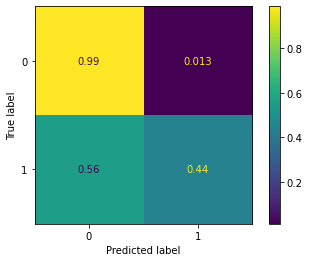

In [32]:
#Compute baseline F1 Score (and other metrics)

print('Accuracy:', accuracy_score(devLabels, summaryDF.testPredict2))
print('F1 score:', f1_score(devLabels, summaryDF.testPredict2))
print('Recall:', recall_score(devLabels, summaryDF.testPredict2))
print('Precision:', precision_score(devLabels, summaryDF.testPredict2))
print('\n Clasification report:\n', classification_report(devLabels, summaryDF.testPredict2))
print('\n Confusion matrix:\n')
disp = plot_confusion_matrix(lr_clf, vDev, devLabels, normalize='true')

In [33]:
# Save down the model
from joblib import dump, load

dump(lr_clf, 'lrmodel.joblib')
dump(vectorizer, 'lr_cv.joblib')
dump(optimumThreshold, 'lr_ot.joblib')


['lr_ot.joblib']

# Brief Exploratory Data Analysis

Let's do a brief data eploratory analysis. Our main goal here is detecting whethere there are human observable patterns that the ML algorithms can pick up with more sofistication. To achieve this, we'll do word clouds for insincere questions (target == 1), and sincere questions (target == 0), and we'll also look at the top 50 words on each class. 

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from collections import Counter
# importing NLTK libarary stopwords 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
!pip install Wordcloud

     |████████████████████████████████| 220 kB 3.1 MB/s eta 0:00:01
  Created wheel for Wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158019 sha256=4fc38d8e6964222ebaf62ad88d67999505fec1ca10556dd39ed28ca811e88f02
  Stored in directory: /Users/julian.hicks/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built Wordcloud
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [38]:
insincereDF = train[train['label'] == 1]

sincereDF = train[train['label'] == 0]

There are 6394938 words in the combination of all review.


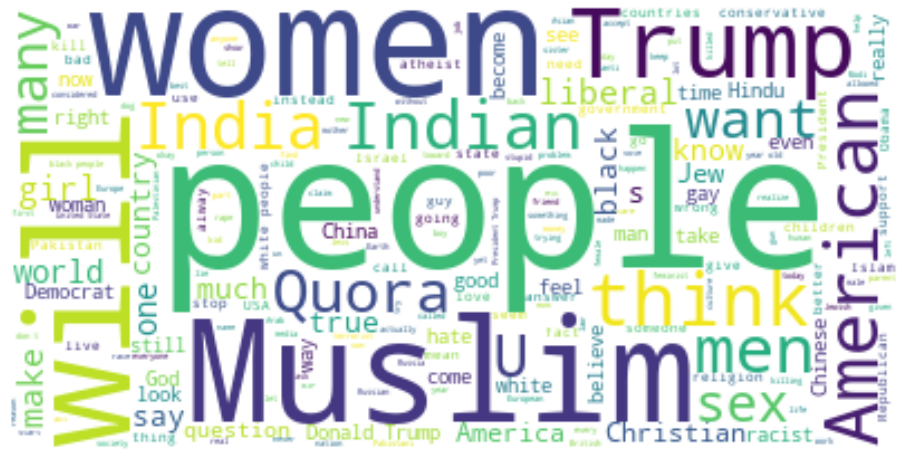

In [42]:
insincereQWords = " ".join(review for review in insincereDF.text)

print ("There are {} words in the combination of all review.".format(len(insincereQWords)))

# Generate a word cloud image
insincereWordCloud = WordCloud(background_color="white").generate(insincereQWords)

# Display the generated image:
figure(figsize=(16, 12))
plt.imshow(insincereWordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 68504296 words in the combination of all review.


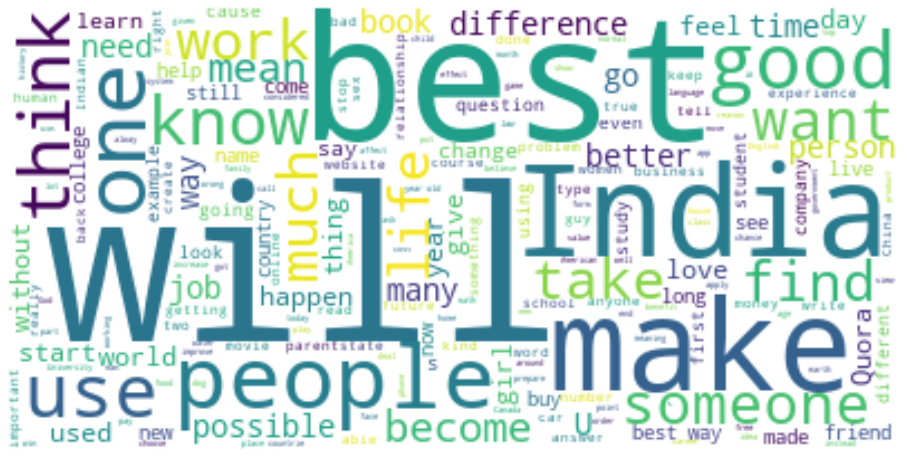

In [43]:
sincereQWords = " ".join(review for review in sincereDF.text)

print ("There are {} words in the combination of all review.".format(len(sincereQWords)))

# Generate a word cloud image
sincereWordCloud = WordCloud(background_color="white").generate(sincereQWords)

# Display the generated image:
figure(figsize=(16, 12))
plt.imshow(sincereWordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

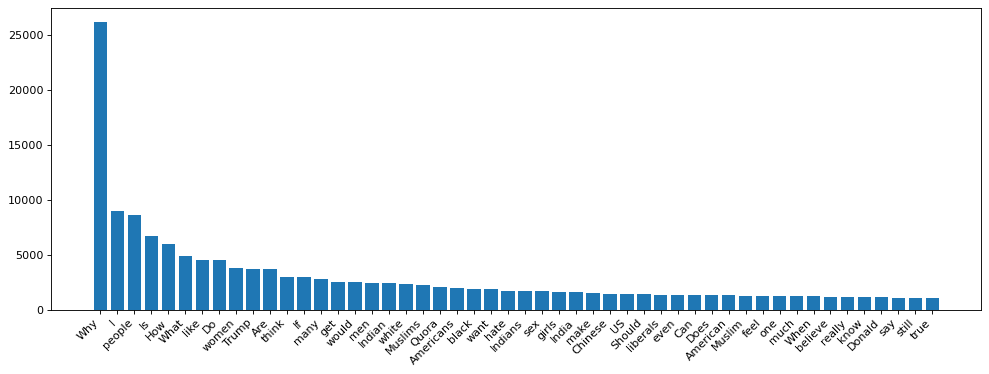

In [44]:
# split() returns list of all the words in the string
splitItInsincere = insincereQWords.split()
  
# Pass the split_it list to instance of Counter class.
counterInsincere = Counter(splitItInsincere)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
mostOccur = counterInsincere.most_common(1000)

#Create an empty list and append words that ARE NOT in the stop words list 
mostOccurNoStop = []

for item in mostOccur:
    if item[0] not in stopwords.words('english'):
        mostOccurNoStop.append(item)

insincereQs_df = pd.DataFrame(data=mostOccurNoStop, columns=['Word','Frequency'])
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(insincereQs_df[:50].Word, insincereQs_df[:50].Frequency)
plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
plt.show()


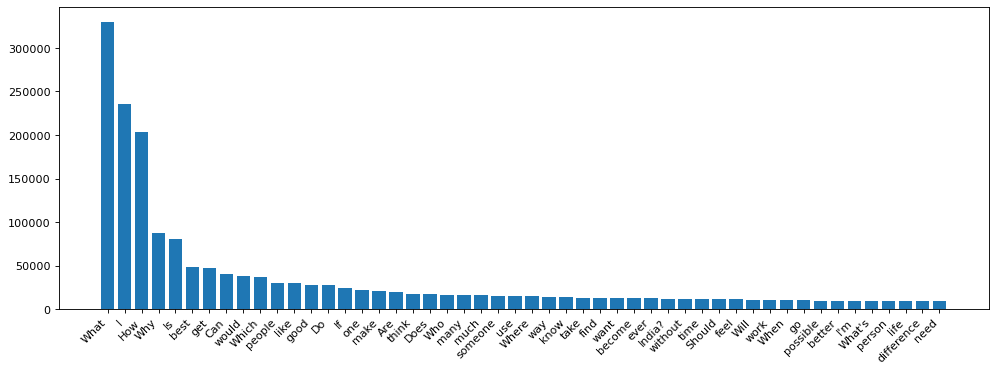

In [45]:
# split() returns list of all the words in the string
splitItSincere = sincereQWords.split()
  
# Pass the split_it list to instance of Counter class.
counterSincere = Counter(splitItSincere)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
mostOccur = counterSincere.most_common(1000)
  
#Create an empty list and append words that ARE NOT in the stop words list
mostOccurNoStop = []

for item in mostOccur:
    if item[0] not in stopwords.words('english'):
        mostOccurNoStop.append(item)

sincereQs_df = pd.DataFrame(data=mostOccurNoStop, columns=['Word','Frequency'])
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(sincereQs_df[:50].Word, sincereQs_df[:50].Frequency)
plt.xticks(rotation = 45, ha='right') # Rotates X-Axis Ticks by 45-degrees
plt.show()

### Exploratory Data Analysis Summary: 

There are definitive patterns that are observable by humans and that the ML algorithms can pick up and potentiate. 

If we look at the top 50 list and wordcloud for **insincere questions**, we'll find words that are closely related to people's anxieties and fears over immigration, gender and political affiliations (_e.g. Muslim, Indian, Men, Women, Mexican, Chinese, Girls, Liberals, etc._); we also find words associated to subjective language (_really, many, much_), as well as words that can be associated to incendiary rhetoric (_hate, make, feels_).

If we look at the top 50 list and wordcloud for **sincere questions**, we can't find the patterns described above. Instead, we find plenty of words with a positive connotation (_better, best, can_), and many neutral words (_person, difference, time, should, want, people, can how, why_). The subjective language pattern is also present here (_much, many_).